In [45]:
%matplotlib inline
import numpy as np
#from autograd import numpy as np
import bayesian_pdes as bpdes
from scipy import stats, linalg
import matplotlib.pyplot as plt
import mcmc
import sympy as sp
import os
import time
import eit
import time
%load_ext mcmc
%mcmc notebook

The mcmc extension is already loaded. To reload it, use:
  %reload_ext mcmc


In [46]:
from IPython.core.magic import register_cell_magic, needs_local_scope
@needs_local_scope
@register_cell_magic
def capture_cell(line, cell):
    globals()[line.strip()] = cell
    exec(cell, globals())

In [47]:
use_dummy_data = False
dummy_data_file = os.path.join('dummy_data', 'centered_blob')

In [48]:
%%capture_cell params
scale = 1000
stim_current = 1.0

kernel_variance_mult = 100.0
kernel_ls = 0.16945313
conductivity_variance_mult = 1.0 # 1e-3 is good
conductivity_ls = 0.3
run_time = 11

likelihood_variance = 1.0 # variance for the observation model - based on the value from RA paper

n_radii_forward = 12
n_radii_inverse = 8
bayesian = True
adapt_ls = False

include_prior_mean = False

n_repeats = 10000
n_iter = 100
thin = 100
restart = False

In [49]:
dest_dir = os.path.join('results', 'static_recovery_f{}_n={}'.format(run_time, n_radii_forward))
if not bayesian:
    dest_dir += '_collocation'
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

In [50]:
with open(os.path.join(dest_dir, 'params.py'), 'w') as f:
    f.write(params)

In [51]:
min_accept = 0.1
max_accept = 0.4

In [52]:
baseline = np.loadtxt('recovered_rhos.csv', delimiter=',')
baseline_xy = baseline[:,:2]
baseline_fields = baseline[:,2:]

# Sheet Parameters

In [53]:
# important helpers!
def plot_circle(x, y, values, cmap=None):
    plt.tricontourf(x.ravel(), y.ravel(), values.ravel(), cmap=cmap)
    plt.colorbar()
    plt.legend()
    plt.axis('scaled')
    plt.xlim(-1.1,1.1); plt.ylim(-1.1,1.1);

In [54]:
# code for setting up the stim pattern
stim_pattern = np.zeros((7,8))
for i in range(7):
    stim_pattern[i,0] = 1
    stim_pattern[i, i+1] = -1
stim_pattern = scale*stim_pattern*stim_current

In [55]:
meas_pattern = np.zeros((7,8))
meas_pattern[:,0] = 1
meas_pattern[:, 1:] = np.diag(-np.ones(7))

In [56]:
pattern = eit.grids.EITPattern(meas_pattern, stim_pattern)

# Load Data

In [57]:
data_file = '../data/ST1trial3.DAT'
raw_data = np.loadtxt(data_file)

In [58]:
raw_data.shape

(49, 50)

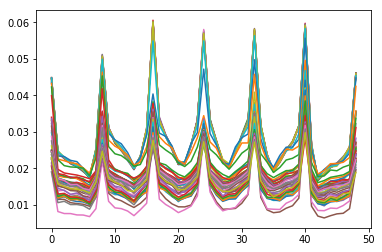

In [59]:
plt.plot(raw_data[:,1:].T);

In [60]:
raw_data.shape

(49, 50)

The data file format is as follows:
* Each row corresponds to a time
* The first element of the row gives the time index of the measurement
* The remaining columns give the measurements for each time
* These are divided into seven blocks.
    - Call the block $i$
    - Within the block the measurements correspond to electrodes $j=1,\dots,8$, $j\neq i$
    - Pair $(i,j)$ represents passing a current between electrode $i$ and electrode $j$ and measuring the voltage.
    - The voltage is measured between the _reference_ electrode at $1$ and the electrode located at $1+i$

_Is there not one too many electrodes here? This implies at some point we measure the voltage between 1 and 2 based on a current driven between 1 and 2._

_Is there a linear independence problem here? I still think there might be._

In [61]:
def data_to_dict(data):
    res = {}
    for r in data:
        time = r[0]
        other_data = r[1:]
        res[time] = scale*other_data.reshape((7,7))
    return res

In [62]:
data_dict = data_to_dict(raw_data)
# quick check to make sure the data dict matches expectation
assert np.all(data_dict[1][0] == scale*raw_data[0][1:8])

In [63]:
dummy_data = np.load(os.path.join(dummy_data_file, 'obs.npy'))
dummy_true_field = np.load(os.path.join(dummy_data_file, 'theta.npy'))

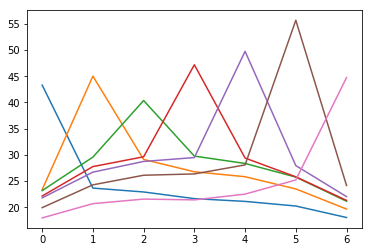

In [64]:
plt.plot(data_dict[run_time]);

# Set Up

In [65]:
s_x, s_xbar, s_y, s_ybar = sp.symbols('x,xbar,y,ybar')
a, a_x, a_y = sp.symbols('a,a_x,a_y')
a_bar, a_x_bar, a_y_bar = sp.symbols('abar,a_xbar,a_ybar')
s_length_scale, s_variance = sp.symbols('l,sigma')
kernel = s_variance*sp.exp(-((s_x-s_xbar)**2 + (s_y-s_ybar)**2) / (2.*s_length_scale**2))
symbols = [[s_x, s_y, a, a_x, a_y], [s_xbar, s_ybar, a_bar, a_x_bar, a_y_bar], [s_length_scale, s_variance]]

Use:
\begin{align*}
    \nabla \cdot (\exp(a)\nabla u) &= \nabla \exp(a) \cdot \nabla u + \exp(a) \nabla^2 u \\
    &= \exp(a) \left( \nabla a \cdot \nabla u + \nabla^2 u \right) \\
    &= \exp(a) \left( a_x u_x + a_y u_y + u_{xx} + u_{yy} \right)
\end{align*}
and:
\begin{align*}
    \exp(a) \nabla u \cdot n &= \exp(a) (x u_x + y u_y)
\end{align*}
for the special case of a unit circular domain centered at the origin.

## Define the collocation grid

In [66]:
n_in_shell = n_radii_forward
n_bdy = 32
n_sensor = 8
grid = eit.grids.construct_circular(n_in_shell, n_bdy, n_sensor)

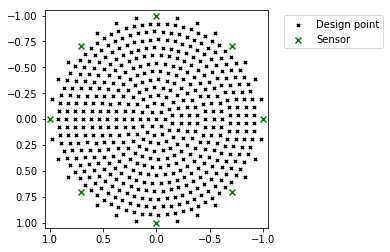

In [67]:
# plot design points
plt.figure(figsize=(4,4))
plt.scatter(grid.interior[:,0], grid.interior[:,1], marker='x', color='black', s=10)
plt.scatter(grid.boundary[:,0], grid.boundary[:,1], marker='x', color='black', s=10, label='Design point')
plt.scatter(grid.sensors[:,0], grid.sensors[:,1], marker='x', color='green', label='Sensor')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)
plt.legend(loc=2, bbox_to_anchor=(1.05,1))

In [68]:
print(len(grid.all))

523


## Set up Proposal Matrix

In [69]:
proposal_kernel = kernel
def diff_x(k):
    return k.diff(s_x)
def diff_y(k):
    return k.diff(s_y)
def diff_x_bar(k):
    return k.diff(s_xbar)
def diff_y_bar(k):
    return k.diff(s_ybar)

proposal_op_system = bpdes.operator_compilation.sympy_gram.compile_sympy(
    [diff_x, diff_y], 
    [diff_x_bar, diff_y_bar], 
    proposal_kernel,
    [[s_x, s_y], [s_xbar, s_ybar], [s_length_scale, s_variance]]
)

In [70]:
proposal_design = eit.grids.construct_shell(np.linspace(0,1,n_radii_inverse))

(1.05, -1.05)

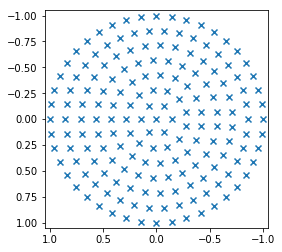

In [71]:

plt.figure(figsize=(4,4))
plt.scatter(proposal_design[:,0], proposal_design[:,1], marker='x')
plt.xlim(1.05,-1.05);plt.ylim(1.05,-1.05)

In [72]:
full_design = np.row_stack([grid.interior_plus_boundary, grid.sensors])
proposal_fun_args = np.array([conductivity_ls, conductivity_variance_mult])
proposal_cov = bpdes.collocation.compute_operator_matrix(
    [()],
    [()],
    [proposal_design],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_lhs_mat = bpdes.collocation.compute_operator_matrix(
    [(), diff_x, diff_y], 
    [()],
    [full_design, grid.interior, grid.interior],
    [proposal_design],
    proposal_op_system,
    proposal_fun_args
)
proposal_cov_inv = np.linalg.inv(proposal_cov)
np.linalg.cond(proposal_cov)

5646664006.6509323

In [73]:
proposal_lhs_mat

array([[ 1.        ,  0.8928125 ,  0.8928125 , ...,  0.00386592,
         0.00386592,  0.00386592],
       [ 0.96766134,  0.97613765,  0.91832701, ...,  0.00814   ,
         0.00849439,  0.00871746],
       [ 0.96766134,  0.91832701,  0.97613765, ...,  0.00405752,
         0.00457602,  0.00513966],
       ..., 
       [ 0.02242961,  0.08277885,  0.04570079, ..., -1.70218516,
        -0.55758129,  0.88311134],
       [ 0.01504105,  0.05694508,  0.04036482, ..., -1.98714398,
        -1.27933778,  0.12460335],
       [ 0.00754699,  0.02901559,  0.03271365, ..., -1.98939299,
        -1.78544152, -0.68727413]])

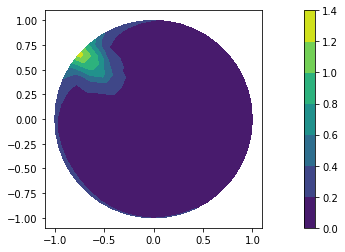

In [74]:
rhomin = 0.01
rho = baseline_fields[:,run_time-1][:,None]
rho[rho < rhomin] = rhomin
conduct = np.log(1./rho)
p = bpdes.collocate([()], [()], 
                    [(baseline_xy, conduct)],
                    proposal_op_system, 
                    np.array([0.12, 1.0]))

true_field, _ = p(proposal_design)
true_field = true_field.ravel()
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(true_field))

In [75]:
# TO DO:
# * Swap to simulating only a lower dimensional version of the field
proposal_dot_mat = np.dot(proposal_lhs_mat, proposal_cov_inv)

# Set Up The Potential

In [76]:
# todo: choose this in a more principled way
length_scale = kernel_ls
fun_args = np.array([kernel_ls, kernel_variance_mult])
data = data_dict[run_time] if not use_dummy_data else dummy_data


In [77]:
# choose an initial field
import scipy.optimize
def phi_const(k):
    theta = k*np.ones(proposal_cov.shape[0])
    return eit.pcn_kernel.phi_c(grid, theta, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)
    
best_const = scipy.optimize.minimize_scalar(phi_const)

In [78]:
# construct the proposal
beta = 0.05
if include_prior_mean:
    prior_mean = best_const.x*np.ones(proposal_cov.shape[0])
else:
    prior_mean = np.zeros(proposal_cov.shape[0])
sqrt_proposal_cov = np.real_if_close(linalg.sqrtm(proposal_cov))

proposal = mcmc.pcn.proposal(beta, proposal_cov, prior_mean)

pcn_kernel = eit.pcn_kernel.PCNKernel_C(beta, prior_mean, sqrt_proposal_cov, grid, likelihood_variance, pattern, data, fun_args, proposal_dot_mat)

In [79]:
if not restart:
    kappa_0 = best_const.x*np.ones(proposal_cov.shape[0])
else:
    seed_file = os.path.join(dest_dir, 'results.npy')
    kappa_0 = np.load(seed_file)[-1]

beta_0 = 0.05    

In [80]:
print(pcn_kernel.phi(kappa_0, debug=True, bayesian=bayesian))

128.71602493804448


In [81]:
proposal_dot_mat.shape

(1505, 177)

In [82]:
len(grid.sensors)

8

In [83]:
len(grid.all) + 2*len(grid.interior)

1505

In [84]:
np.dot(proposal_dot_mat, kappa_0)

array([  2.29879995e+00,   2.29880331e+00,   2.29880330e+00, ...,
        -4.48175249e-03,  -3.00560320e-03,  -1.50819620e-03])

In [85]:
mu, cov = pcn_kernel.get_posterior(kappa_0, grid.sensors)
print(np.dot(np.dot(meas_pattern, cov), meas_pattern.T))

[[ 1.77977106  1.75337316  1.47456185  1.09051279  0.66761273  0.32130411
  -0.01223764]
 [ 1.75337316  3.50986929  3.24399729  2.52648915  1.7557855   0.98657673
   0.26851505]
 [ 1.47456185  3.24399729  4.70378968  4.03640723  2.93224434  1.77898659
   0.68977556]
 [ 1.09051279  2.52648915  4.03640723  5.09468972  4.0034662   2.57139701
   1.0609254 ]
 [ 0.66761273  1.7557855   2.93224434  4.0034662   4.69513643  3.23666927
   1.44544524]
 [ 0.32130411  0.98657673  1.77898659  2.57139701  3.23666927  3.55797332
   1.7789869 ]
 [-0.01223764  0.26851505  0.68977556  1.0609254   1.44544524  1.7789869
   1.72451836]]


In [86]:
def ls_log_prior(ls):
    if ls < 0:
        return -np.inf
    return scipy.stats.halfcauchy.logpdf(ls)

In [87]:
#kappa_0 = res[-1,:]
#length_scale = length_scales[-1]

In [88]:

beta = beta_0
per_repeat = int(n_iter/thin)
res = np.empty((per_repeat*n_repeats, kappa_0.shape[0]))

cur_length_scale = length_scale
pcn_kernel.collocate_args = np.array([cur_length_scale, kernel_variance_mult])
length_scales = np.empty(n_repeats)
length_scale_proposals = np.empty(n_repeats)
accepts = np.zeros(n_repeats, dtype=np.bool)
length_scale_proposal_variance = 1e-3
cur_ls_log_prior = ls_log_prior(length_scale)

start = kappa_0.reshape((1, kappa_0.shape[0]), order='F')

average_time = 0.
for i in range(n_repeats):
    init_time = time.time()
    proposals, acceptances, log_likelihoods = pcn_kernel.apply(start, n_iter, n_threads=8, beta=beta, bayesian=bayesian)
    took = time.time() - init_time
    average_time = (average_time * (i) + took) / (i+1)
    if acceptances.mean() < min_accept:
        beta *= 0.75
    elif acceptances.mean() > max_accept:
        beta /= 0.75
    if beta > 1:
        beta = 1.
    res[per_repeat*i:per_repeat*(i+1)] = proposals[::thin]
    start = proposals[-1,:].reshape(start.shape, order='F')
    
    if adapt_ls:
        # propose to change length_scale
        new_length_scale = np.random.normal(cur_length_scale, length_scale_proposal_variance)
        length_scale_proposals[i] = new_length_scale
        new_ls_log_prior = ls_log_prior(new_length_scale)

        if np.isneginf(new_ls_log_prior):
            accept = False
        else:
            cur_phi = pcn_kernel.phi(start.ravel())
            new_phi = pcn_kernel.phi(start.ravel(), np.array([new_length_scale, kernel_variance_mult]))
            accept_prob = np.exp(cur_phi - new_phi + new_ls_log_prior - cur_ls_log_prior)
            accept = np.random.uniform() < accept_prob
        if accept:
            cur_length_scale = new_length_scale
            cur_ls_log_prior = new_ls_log_prior
            pcn_kernel.collocate_args = np.array([cur_length_scale, kernel_variance_mult])
    else:
        accept = False
    accepts[i] = accept
    length_scales[i] = cur_length_scale
    if i > 100:
        if np.mean(accepts[i-99:i+1]) < min_accept:
            length_scale_proposal_variance *= 0.75
        elif np.mean(accepts[i-99:i+1]) > max_accept:
            length_scale_proposal_variance /= 0.75
        
    if i % 100 == 0:
        print('{}: accept={} beta={} ls={} accept={} t/iter={:.2}s'.format(i, acceptances.mean(), beta, cur_length_scale, np.mean(accepts[:i+1]), average_time))
#print log_likelihoods.mean()

0: accept=0.35 beta=0.05 ls=0.16945313 accept=0.0 t/iter=2.8s
100: accept=0.3 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
200: accept=0.23 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
300: accept=0.29 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
400: accept=0.39 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
500: accept=0.19 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
600: accept=0.29 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
700: accept=0.34 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
800: accept=0.22 beta=0.05000000000000001 ls=0.16945313 accept=0.0 t/iter=2.8s
900: accept=0.26 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
1000: accept=0.28 beta=0.037500000000000006 ls=0.16945313 accept=0.0 t/iter=2.8s
1100: accept=0.16 beta=0.05000000000000001 ls=0.16945313 accept=0.0 t/iter=2.8s
1200: accept=0.19 beta=0.037500000000000006 ls=0.16945313 a

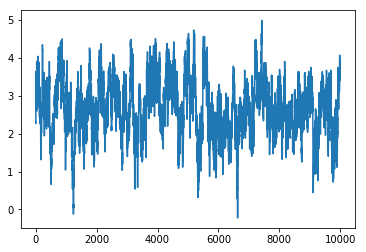

In [89]:
plt.plot(res[:,4])

In [90]:
proposal.beta=1e-4
proposal(res[-1])

array([ 3.0533927 ,  2.34008965,  2.08237957,  2.9737038 ,  3.87355291,
        3.87244107,  3.23476422,  1.98702309,  1.41546294,  1.62990295,
        2.25778775,  2.76411859,  3.31012467,  3.96253225,  4.23574056,
        4.21915448,  4.03411666,  3.66474348,  3.26072634,  2.7489613 ,
        1.89015461,  1.41746022,  1.49620053,  2.14187244,  2.73871399,
        2.8883045 ,  2.76202581,  2.78558386,  3.28637352,  3.81752656,
        3.78490346,  3.61189957,  3.74058218,  3.8810653 ,  3.79256733,
        3.48434236,  3.05642813,  2.72787385,  2.41156133,  2.08464875,
        1.83610798,  1.77928108,  2.17784239,  2.83829529,  3.28579109,
        3.25951448,  2.94438052,  2.6099439 ,  2.39168262,  2.61669343,
        3.30161639,  3.69695816,  3.36216407,  2.83350419,  2.75202281,
        3.10179486,  3.46225447,  3.65726972,  3.57466606,  3.11162466,
        2.51875787,  2.23946583,  2.32119674,  2.30780931,  2.40193061,
        2.36820301,  2.26034062,  2.23950458,  2.50013465,  2.85

In [91]:
pcn_kernel.phi(res[-1])

66.63578912909612

In [92]:
pcn_kernel.phi(proposal(res[-1]))

66.63447686460252

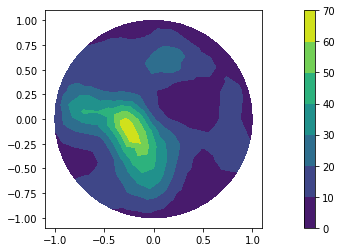

In [93]:
plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(np.mean(res[-1:], axis=0)))

In [94]:
if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)
np.save(os.path.join(dest_dir, 'results.npy'), res)
np.save(os.path.join(dest_dir, 'length_scales.npy'), length_scales)
np.save(os.path.join(dest_dir, 'field_pts.npy'), proposal_design)

plot_circle(proposal_design[:,0], proposal_design[:,1], np.exp(np.mean(res[40000:], axis=0)))
plt.savefig(os.path.join(dest_dir, 'mean.pdf'), bbox_inches=0, transparent=True)
plt.close()

/home/jon/.virtualenvs/stats/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  The arithmetic mean is the sum of the elements along the axis divided
/home/jon/.virtualenvs/stats/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
